In [1]:
import pandas as pd
import numpy as np
import re

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [2]:
data = pd.read_csv('data/annual_stock.csv')
data

,Stock number,Year (end of the year),Total fixed assets,Interest -free liability,Interest -free non -current liabilities,Interest liabilities,Interest debt,Net debt,Formal asset,Operating capital,...,Cash and cash equivalent net increase,Add: At the beginning of the period of cash and cash equivalent,Special items for cash and cash equivalents,The amount of adjustment of the net increase in cash and cash equivalent,At the end of the period of cash and cash equivalent,High transfer preparation announcement date,High transfer of equity registration date,High transfer removal day,Turn per share,Whether to transfer
0,1,1,8.691229e+07,1.422495e+09,1.600192e+08,8.198551e+08,8.271884e+08,3.578747e+08,8.929308e+08,5.904970e+08,...,-7.615285e+07,5.454666e+08,NaN,NaN,4.693137e+08,3月30日,NaN,NaN,NaN,0
1,1,2,7.887817e+07,1.903724e+09,1.487364e+08,3.749099e+08,3.942266e+08,-4.034978e+08,1.190906e+09,9.114353e+08,...,3.284106e+08,4.693137e+08,NaN,NaN,7.977243e+08,3月30日,NaN,NaN,NaN,0
2,1,3,7.530102e+07,1.447218e+09,1.418316e+08,3.643167e+08,4.805600e+08,-4.966118e+08,1.501162e+09,1.333070e+09,...,1.794475e+08,7.977243e+08,NaN,NaN,9.771718e+08,4月1日,6月19日,6月20日,0.25,0
3,1,4,6.406923e+07,1.388840e+09,1.367301e+08,1.050000e+08,2.826134e+08,-5.263500e+08,1.755344e+09,1.697810e+09,...,-1.682084e+08,9.771718e+08,NaN,NaN,8.089634e+08,4月1日,6月8日,6月9日,0.22,0
4,1,5,8.592952e+07,1.870206e+09,1.347049e+08,1.292434e+08,2.740834e+08,-6.716566e+08,1.764907e+09,1.665822e+09,...,1.243744e+08,8.089634e+08,NaN,NaN,9.333378e+08,3月31日,5月23日,5月24日,0.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,3466,3,1.749089e+08,9.162246e+07,1.583035e+07,6.589091e+07,6.589091e+07,9.880669e+06,2.252468e+08,6.080053e+07,...,1.811266e+07,3.400758e+07,NaN,NaN,5.212024e+07,NaN,NaN,NaN,NaN,0
24258,3466,4,1.674375e+08,1.017815e+08,1.360359e+07,2.314488e+07,2.314488e+07,-1.139792e+08,3.873122e+08,2.294332e+08,...,7.917448e+07,5.212024e+07,NaN,NaN,1.312947e+08,4月9日,5月22日,5月25日,0.20,0
24259,3466,5,1.627839e+08,8.110693e+07,1.326047e+07,1.415562e+07,1.415562e+07,-1.464317e+06,3.651500e+08,2.133559e+08,...,-1.178085e+08,1.312947e+08,NaN,NaN,1.348623e+07,4月26日,6月6日,6月7日,0.11,0
24260,3466,6,1.897513e+08,1.432359e+08,1.203168e+07,2.974001e+07,2.974001e+07,-4.736971e+07,3.793057e+08,2.000272e+08,...,5.956293e+07,1.348623e+07,NaN,NaN,7.304916e+07,4月26日,6月7日,6月8日,0.11,0


#### Step 1: Handling missing values

In [3]:
# Check the percentage of missing values in each column
missing_values = data.isnull().mean() * 100

# Removing columns with a high percentage of missing values (e.g., more than 50% missing)
threshold = 50  # percentage
columns_to_drop = missing_values[missing_values > threshold].index
data_cleaned = data.drop(columns=columns_to_drop)

# Removing columns that are not useful for the analysis
data_cleaned.drop(columns=['High transfer preparation announcement date', 'High transfer of equity registration date',
                           'High transfer removal day'], inplace=True)

# Removing rows with a high percentage of missing values 
rows_to_drop = data_cleaned.isnull().mean(axis=1) * 100 > threshold
data_cleaned = data_cleaned[~rows_to_drop]


# For the remaining columns, if they are numeric, fill missing values with the median, 
# and if they are categorical, fill with the mode
for col in data_cleaned.columns:
    if data_cleaned[col].dtype == 'object':
        # fill with the most frequent value (mode)
        data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mode()[0])
    else:
        # fill with median
        data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].median())

# Display the updated DataFrame
data_cleaned


,Stock number,Year (end of the year),Total fixed assets,Interest -free liability,Interest -free non -current liabilities,Interest liabilities,Interest debt,Net debt,Formal asset,Operating capital,...,"Dividement, profit, or payment of interest payment cash",Payment other cash related to fundraising activities,Cash outflow of fundraising activities,Net cash flow from financing activities,effect of the changes of the exchange rate on cash and the equivalents,Cash and cash equivalent net increase,Add: At the beginning of the period of cash and cash equivalent,At the end of the period of cash and cash equivalent,Turn per share,Whether to transfer
0,1,1,8.691229e+07,1.422495e+09,1.600192e+08,8.198551e+08,8.271884e+08,3.578747e+08,8.929308e+08,5.904970e+08,...,4.396870e+07,1396200.00,3.243249e+08,2.881703e+08,-217885.53,-7.615285e+07,5.454666e+08,4.693137e+08,0.13,0
1,1,2,7.887817e+07,1.903724e+09,1.487364e+08,3.749099e+08,3.942266e+08,-4.034978e+08,1.190906e+09,9.114353e+08,...,4.891714e+07,1584500.00,6.694635e+08,-4.834635e+08,1103.36,3.284106e+08,4.693137e+08,7.977243e+08,0.13,0
2,1,3,7.530102e+07,1.447218e+09,1.418316e+08,3.643167e+08,4.805600e+08,-4.966118e+08,1.501162e+09,1.333070e+09,...,2.337307e+07,1677492.00,3.973809e+08,6.386246e+07,-801465.87,1.794475e+08,7.977243e+08,9.771718e+08,0.25,0
3,1,4,6.406923e+07,1.388840e+09,1.367301e+08,1.050000e+08,2.826134e+08,-5.263500e+08,1.755344e+09,1.697810e+09,...,1.787611e+08,17131885.01,6.930777e+08,-3.767077e+08,-1093973.32,-1.682084e+08,9.771718e+08,8.089634e+08,0.22,0
4,1,5,8.592952e+07,1.870206e+09,1.347049e+08,1.292434e+08,2.740834e+08,-6.716566e+08,1.764907e+09,1.665822e+09,...,1.492891e+08,104500.00,3.743936e+08,-1.579236e+08,2757607.83,1.243744e+08,8.089634e+08,9.333378e+08,0.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,3466,3,1.749089e+08,9.162246e+07,1.583035e+07,6.589091e+07,6.589091e+07,9.880669e+06,2.252468e+08,6.080053e+07,...,2.466474e+07,17131885.01,5.466474e+07,5.335261e+06,-8344.27,1.811266e+07,3.400758e+07,5.212024e+07,0.13,0
24258,3466,4,1.674375e+08,1.017815e+08,1.360359e+07,2.314488e+07,2.314488e+07,-1.139792e+08,3.873122e+08,2.294332e+08,...,1.615895e+07,17131885.01,9.615895e+07,6.047802e+07,-8344.27,7.917448e+07,5.212024e+07,1.312947e+08,0.20,0
24259,3466,5,1.627839e+08,8.110693e+07,1.326047e+07,1.415562e+07,1.415562e+07,-1.464317e+06,3.651500e+08,2.133559e+08,...,1.562120e+07,17131885.01,1.562120e+07,-1.110120e+07,-8344.27,-1.178085e+08,1.312947e+08,1.348623e+07,0.11,0
24260,3466,6,1.897513e+08,1.432359e+08,1.203168e+07,2.974001e+07,2.974001e+07,-4.736971e+07,3.793057e+08,2.000272e+08,...,8.697808e+06,17131885.01,8.697808e+06,-6.697808e+06,-8344.27,5.956293e+07,1.348623e+07,7.304916e+07,0.11,0


#### Step 2: Handling outliers

In [4]:
import numpy as np

# For each numeric column, replace outliers (values outside the 1st and 99th percentiles) with the median
for col in data_cleaned.select_dtypes(include=np.number).columns:
    lower_bound = data_cleaned[col].quantile(0.01)
    upper_bound = data_cleaned[col].quantile(0.99)
    median = data_cleaned[col].median()
    data_cleaned[col] = np.where(data_cleaned[col] < lower_bound, median, data_cleaned[col])
    data_cleaned[col] = np.where(data_cleaned[col] > upper_bound, median, data_cleaned[col])

# Display the updated DataFrame
data_cleaned


,Stock number,Year (end of the year),Total fixed assets,Interest -free liability,Interest -free non -current liabilities,Interest liabilities,Interest debt,Net debt,Formal asset,Operating capital,...,"Dividement, profit, or payment of interest payment cash",Payment other cash related to fundraising activities,Cash outflow of fundraising activities,Net cash flow from financing activities,effect of the changes of the exchange rate on cash and the equivalents,Cash and cash equivalent net increase,Add: At the beginning of the period of cash and cash equivalent,At the end of the period of cash and cash equivalent,Turn per share,Whether to transfer
0,1731.0,1.0,8.691229e+07,1.422495e+09,1.600192e+08,8.198551e+08,8.271884e+08,3.578747e+08,8.929308e+08,5.904970e+08,...,4.396870e+07,1396200.00,3.243249e+08,2.881703e+08,-217885.53,-7.615285e+07,5.454666e+08,4.693137e+08,0.13,0.0
1,1731.0,2.0,7.887817e+07,1.903724e+09,1.487364e+08,3.749099e+08,3.942266e+08,-4.034978e+08,1.190906e+09,9.114353e+08,...,4.891714e+07,1584500.00,6.694635e+08,-4.834635e+08,1103.36,3.284106e+08,4.693137e+08,7.977243e+08,0.13,0.0
2,1731.0,3.0,7.530102e+07,1.447218e+09,1.418316e+08,3.643167e+08,4.805600e+08,-4.966118e+08,1.501162e+09,1.333070e+09,...,2.337307e+07,1677492.00,3.973809e+08,6.386246e+07,-801465.87,1.794475e+08,7.977243e+08,9.771718e+08,0.25,0.0
3,1731.0,4.0,6.406923e+07,1.388840e+09,1.367301e+08,1.050000e+08,2.826134e+08,-5.263500e+08,1.755344e+09,1.697810e+09,...,1.787611e+08,17131885.01,6.930777e+08,-3.767077e+08,-1093973.32,-1.682084e+08,9.771718e+08,8.089634e+08,0.22,0.0
4,1731.0,5.0,8.592952e+07,1.870206e+09,1.347049e+08,1.292434e+08,2.740834e+08,-6.716566e+08,1.764907e+09,1.665822e+09,...,1.492891e+08,104500.00,3.743936e+08,-1.579236e+08,2757607.83,1.243744e+08,8.089634e+08,9.333378e+08,0.08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,1731.0,3.0,1.749089e+08,9.162246e+07,1.583035e+07,6.589091e+07,6.589091e+07,9.880669e+06,2.252468e+08,6.080053e+07,...,2.466474e+07,17131885.01,5.466474e+07,5.335261e+06,-8344.27,1.811266e+07,3.400758e+07,5.212024e+07,0.13,0.0
24258,1731.0,4.0,1.674375e+08,1.017815e+08,1.360359e+07,2.314488e+07,2.314488e+07,-1.139792e+08,3.873122e+08,2.294332e+08,...,1.615895e+07,17131885.01,9.615895e+07,6.047802e+07,-8344.27,7.917448e+07,5.212024e+07,1.312947e+08,0.20,0.0
24259,1731.0,5.0,1.627839e+08,8.110693e+07,1.326047e+07,1.415562e+07,1.415562e+07,-1.464317e+06,3.651500e+08,2.133559e+08,...,1.562120e+07,17131885.01,1.562120e+07,-1.110120e+07,-8344.27,-1.178085e+08,1.312947e+08,1.348623e+07,0.11,0.0
24260,1731.0,6.0,1.897513e+08,1.432359e+08,1.203168e+07,2.974001e+07,2.974001e+07,-4.736971e+07,3.793057e+08,2.000272e+08,...,8.697808e+06,17131885.01,8.697808e+06,-6.697808e+06,-8344.27,5.956293e+07,1.348623e+07,7.304916e+07,0.11,0.0


## Descriptive Statistics Analysis

In [5]:
descriptive_stats = data_cleaned.describe()

descriptive_stats

,Stock number,Year (end of the year),Total fixed assets,Interest -free liability,Interest -free non -current liabilities,Interest liabilities,Interest debt,Net debt,Formal asset,Operating capital,...,"Dividement, profit, or payment of interest payment cash",Payment other cash related to fundraising activities,Cash outflow of fundraising activities,Net cash flow from financing activities,effect of the changes of the exchange rate on cash and the equivalents,Cash and cash equivalent net increase,Add: At the beginning of the period of cash and cash equivalent,At the end of the period of cash and cash equivalent,Turn per share,Whether to transfer
count,22541.000000,22541.000000,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,...,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,2.254100e+04,22541.000000,22541.000000
mean,1735.040238,4.172441,1.917462e+09,1.587513e+09,1.823406e+08,1.303744e+09,2.247496e+09,1.135103e+09,2.736501e+09,8.036546e+08,...,2.415156e+08,1.070485e+08,2.190322e+09,2.825931e+08,-5.320700e+05,1.012395e+08,1.227979e+09,1.354068e+09,0.240916,0.140233
std,970.850423,1.959967,4.815271e+09,3.850346e+09,4.790658e+08,3.209065e+09,6.094858e+09,4.189496e+09,5.704803e+09,2.342964e+09,...,6.609065e+08,3.216593e+08,5.920142e+09,1.317625e+09,1.015162e+07,7.402034e+08,3.771354e+09,4.105403e+09,0.308415,0.347237
min,38.000000,1.000000,3.113377e+06,1.867076e+07,0.000000e+00,0.000000e+00,0.000000e+00,-4.883818e+09,-4.253906e+08,-1.063955e+10,...,3.000000e+05,0.000000e+00,1.532258e+06,-4.166646e+09,-1.037180e+08,-4.366573e+09,7.772777e+06,9.645628e+06,0.010000,0.000000
25%,903.000000,3.000000,1.810061e+08,1.556149e+08,8.833560e+06,4.884793e+07,6.106161e+07,-2.030170e+08,5.405919e+08,1.110639e+08,...,2.045861e+07,7.779576e+06,1.036668e+08,-5.911804e+07,-2.250131e+05,-7.140555e+07,1.276935e+08,1.493845e+08,0.100000,0.000000
50%,1731.000000,4.000000,4.722699e+08,4.066974e+08,3.138337e+07,2.724480e+08,3.630176e+08,2.986566e+07,1.110260e+09,4.292314e+08,...,5.438588e+07,1.713189e+07,3.883540e+08,7.901000e+06,-8.344270e+03,1.215591e+07,3.295042e+08,3.637714e+08,0.130000,0.000000
75%,2570.000000,6.000000,1.322366e+09,1.182798e+09,1.118221e+08,9.651481e+08,1.423432e+09,6.632177e+08,2.369966e+09,1.009092e+09,...,1.592636e+08,3.744481e+07,1.407454e+09,2.568987e+08,2.782607e+04,1.401486e+08,8.107221e+08,8.892529e+08,0.200000,0.000000
max,3433.000000,7.000000,5.054685e+10,4.077590e+10,5.657458e+09,3.199296e+10,6.607669e+10,4.472199e+10,6.742874e+10,2.056085e+10,...,7.936000e+09,3.201575e+09,6.149000e+10,1.406870e+10,8.270148e+07,7.708989e+09,5.296502e+10,5.833804e+10,1.700000,1.000000


Deleting column Accounting Standards because it is not numeric
Deleting column Currency code because it is not numeric


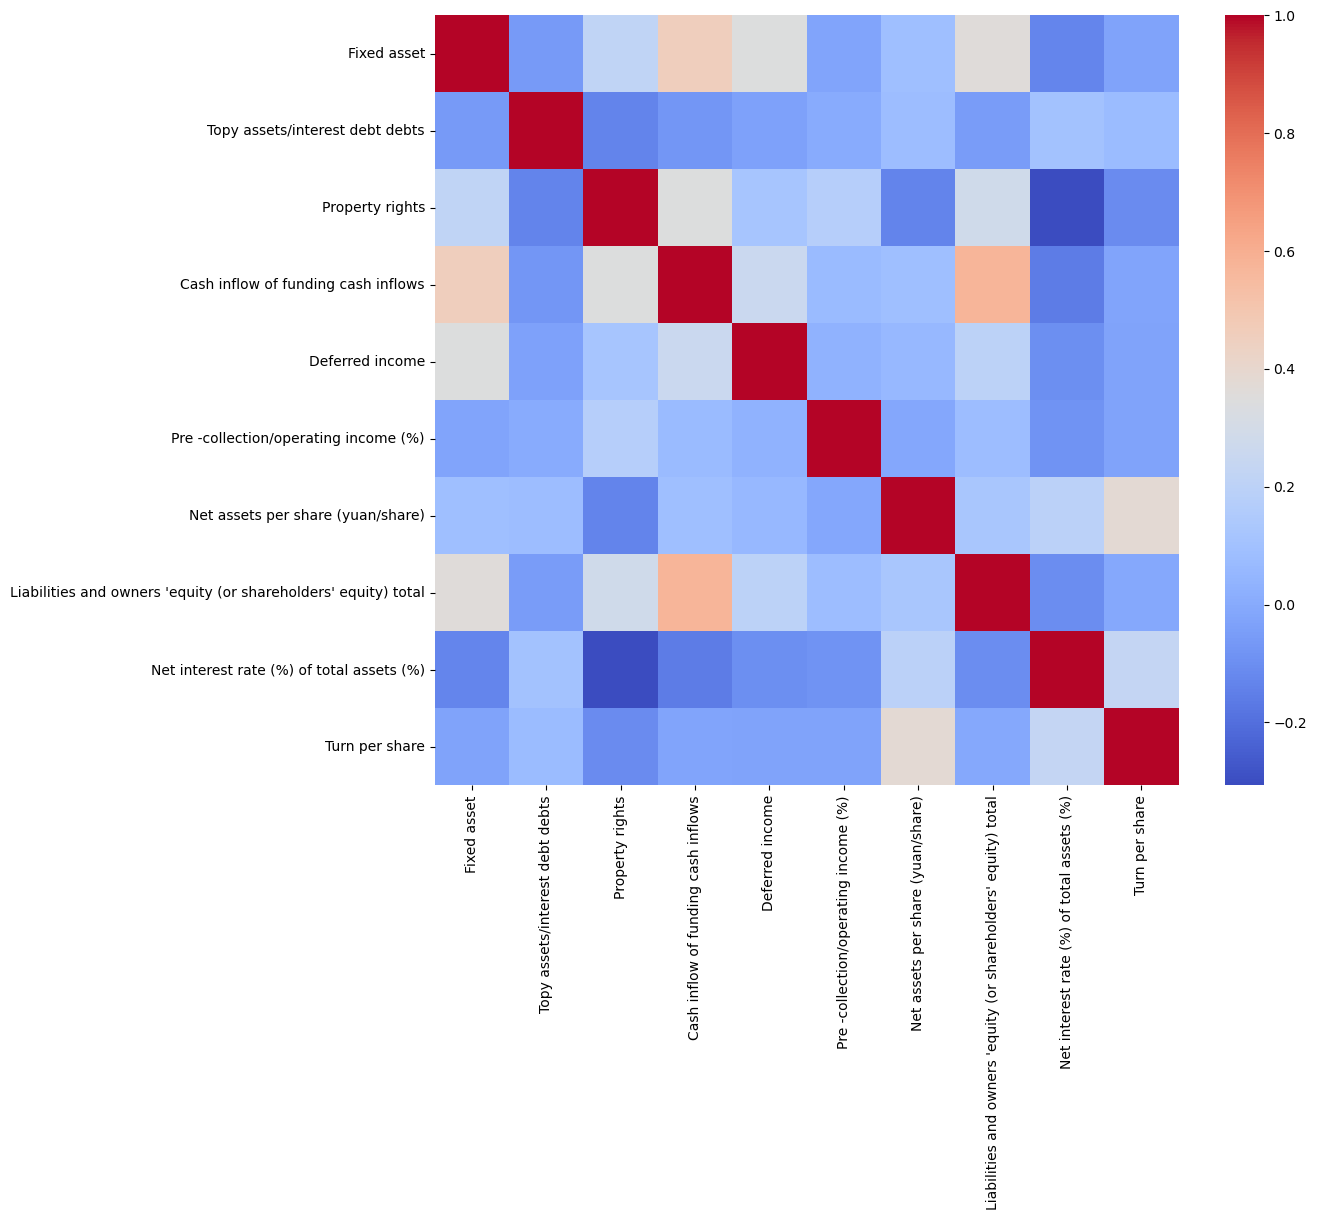

In [6]:
# Get a list of all the column names in the dataframe
all_columns = data_cleaned.columns.tolist()

# Loop through each column name in the list
for column in all_columns:
    # Check if the data type of the column is numeric
    if not pd.api.types.is_numeric_dtype(data_cleaned[column]):
        # If the data type is not numeric, delete the column from the dataframe
        print(f'Deleting column {column} because it is not numeric')
        data_cleaned.drop(column, axis=1, inplace=True)

# correlation matrix with randomly selected 10 columns
corr = data_cleaned.sample(10, axis=1).corr()

# plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='coolwarm')
plt.show()


In [7]:
# according to the correlation matrix, select pair of columns with correlation coefficient > 0.8
corr_matrix = data_cleaned.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('Total fixed assets', 'Fixed asset'),
 ('Interest debt', 'Net debt'),
 ('Interest debt', 'Invest in capital'),
 ('Formal asset', 'The total equity of the owner of the parent company'),
 ('Formal asset', 'Total ownership (or shareholder equity) total'),
 ('retained earnings', 'undistributed profit'),
 ('Net income of business activities',
  'The net profit attributable to shareholders of listed companies after deducting non -recurring profit or loss'),
 ('EBIT', 'Profit of profit tax folding and amortized'),
 ('EBIT', 'Profitable after -tax profit'),
 ('Profit of profit tax folding and amortized',
  'Profitable after -tax profit'),
 ('Earns per share (diluted at the end of the period, yuan/share)',
  'Basic earnings per share'),
 ('Earns per share (diluted at the end of the period, yuan/share)',
  'Business profit per share (yuan/share)'),
 ('Earns per share (diluted at the end of the period, yuan/share)',
  'Before the dividend tax (yuan/share)'),
 ('Basic earnings per share', 'Dilut

#### Data Visualization

#### Feature Selection

To give a quick preview on the company, we manually select five financial factors to perform visualization.

The five financial factors, "Total fixed assets", "Interest debt", "Net debt", "Operating capital", and "Cash and cash equivalent net increase", are crucial in analyzing the situation of high stock dividends (i.e. high ratio of stock dividends or bonus shares). From an economic perspective, these factors reflect a company's financial condition, debt-paying ability, operating capital management, and cash flow situation, all of which are important factors that affect a company's decision to carry out high stock dividends. Below, I will explain the relevance of each factor in detail:

1. **Total Fixed Assets**:
    - Total fixed assets reflect a company's capital investment and asset size. A high amount of fixed assets may indicate that the company has invested a large amount of capital in its business operations. Capital-intensive companies may be more inclined to retain profits to support the maintenance and expansion of their long-term assets, rather than returning them to shareholders through high stock dividends.

2. **Interest Debt**:
    - The level of interest-bearing debt indicates a company's debt level and debt-paying pressure. A high level of interest-bearing debt may mean that the company needs to retain more cash to pay off debt interest, which may limit its ability to carry out high stock dividends.

3. **Net Debt**:
    - Net debt is the difference between a company's total debt and cash and cash equivalents. A higher level of net debt may indicate that the company is under greater pressure to repay debt, which may affect its ability to pay dividends or carry out bonus share issues. 

4. **Operating Capital**:
    - Operating capital is the difference between a company's current assets and current liabilities, and is an important indicator of short-term financial health. Adequate operating capital indicates that the company can meet short-term debt and operational needs. However, too much operating capital may indicate that the company is not effectively using its funds, while tight operating capital may indicate liquidity issues, both of which may affect the company's decision to carry out high stock dividends.

5. **Cash and Cash Equivalent Net Increase**:
    - This indicator measures the increase or decrease in a company's cash and cash equivalents over a certain period of time. Cash flow is the lifeblood of a company's operations, and strong cash flow gives companies greater flexibility when considering shareholder returns (such as high stock dividends). Conversely, companies with tight cash flow may be more conservative in their dividend policies.

In summary, these factors reflect a company's financial condition and operating efficiency from different perspectives, all of which are key factors that affect a company's decision to carry out high stock dividends. By considering these factors comprehensively, we can more fully understand and predict a company's behavior regarding high stock dividends.

In [8]:
selected_factors = [
  'Total fixed assets',
  'Interest debt',
  'Net debt',
  'Operating capital',
  'Cash and cash equivalent net increase'
]


#### Figure Plot

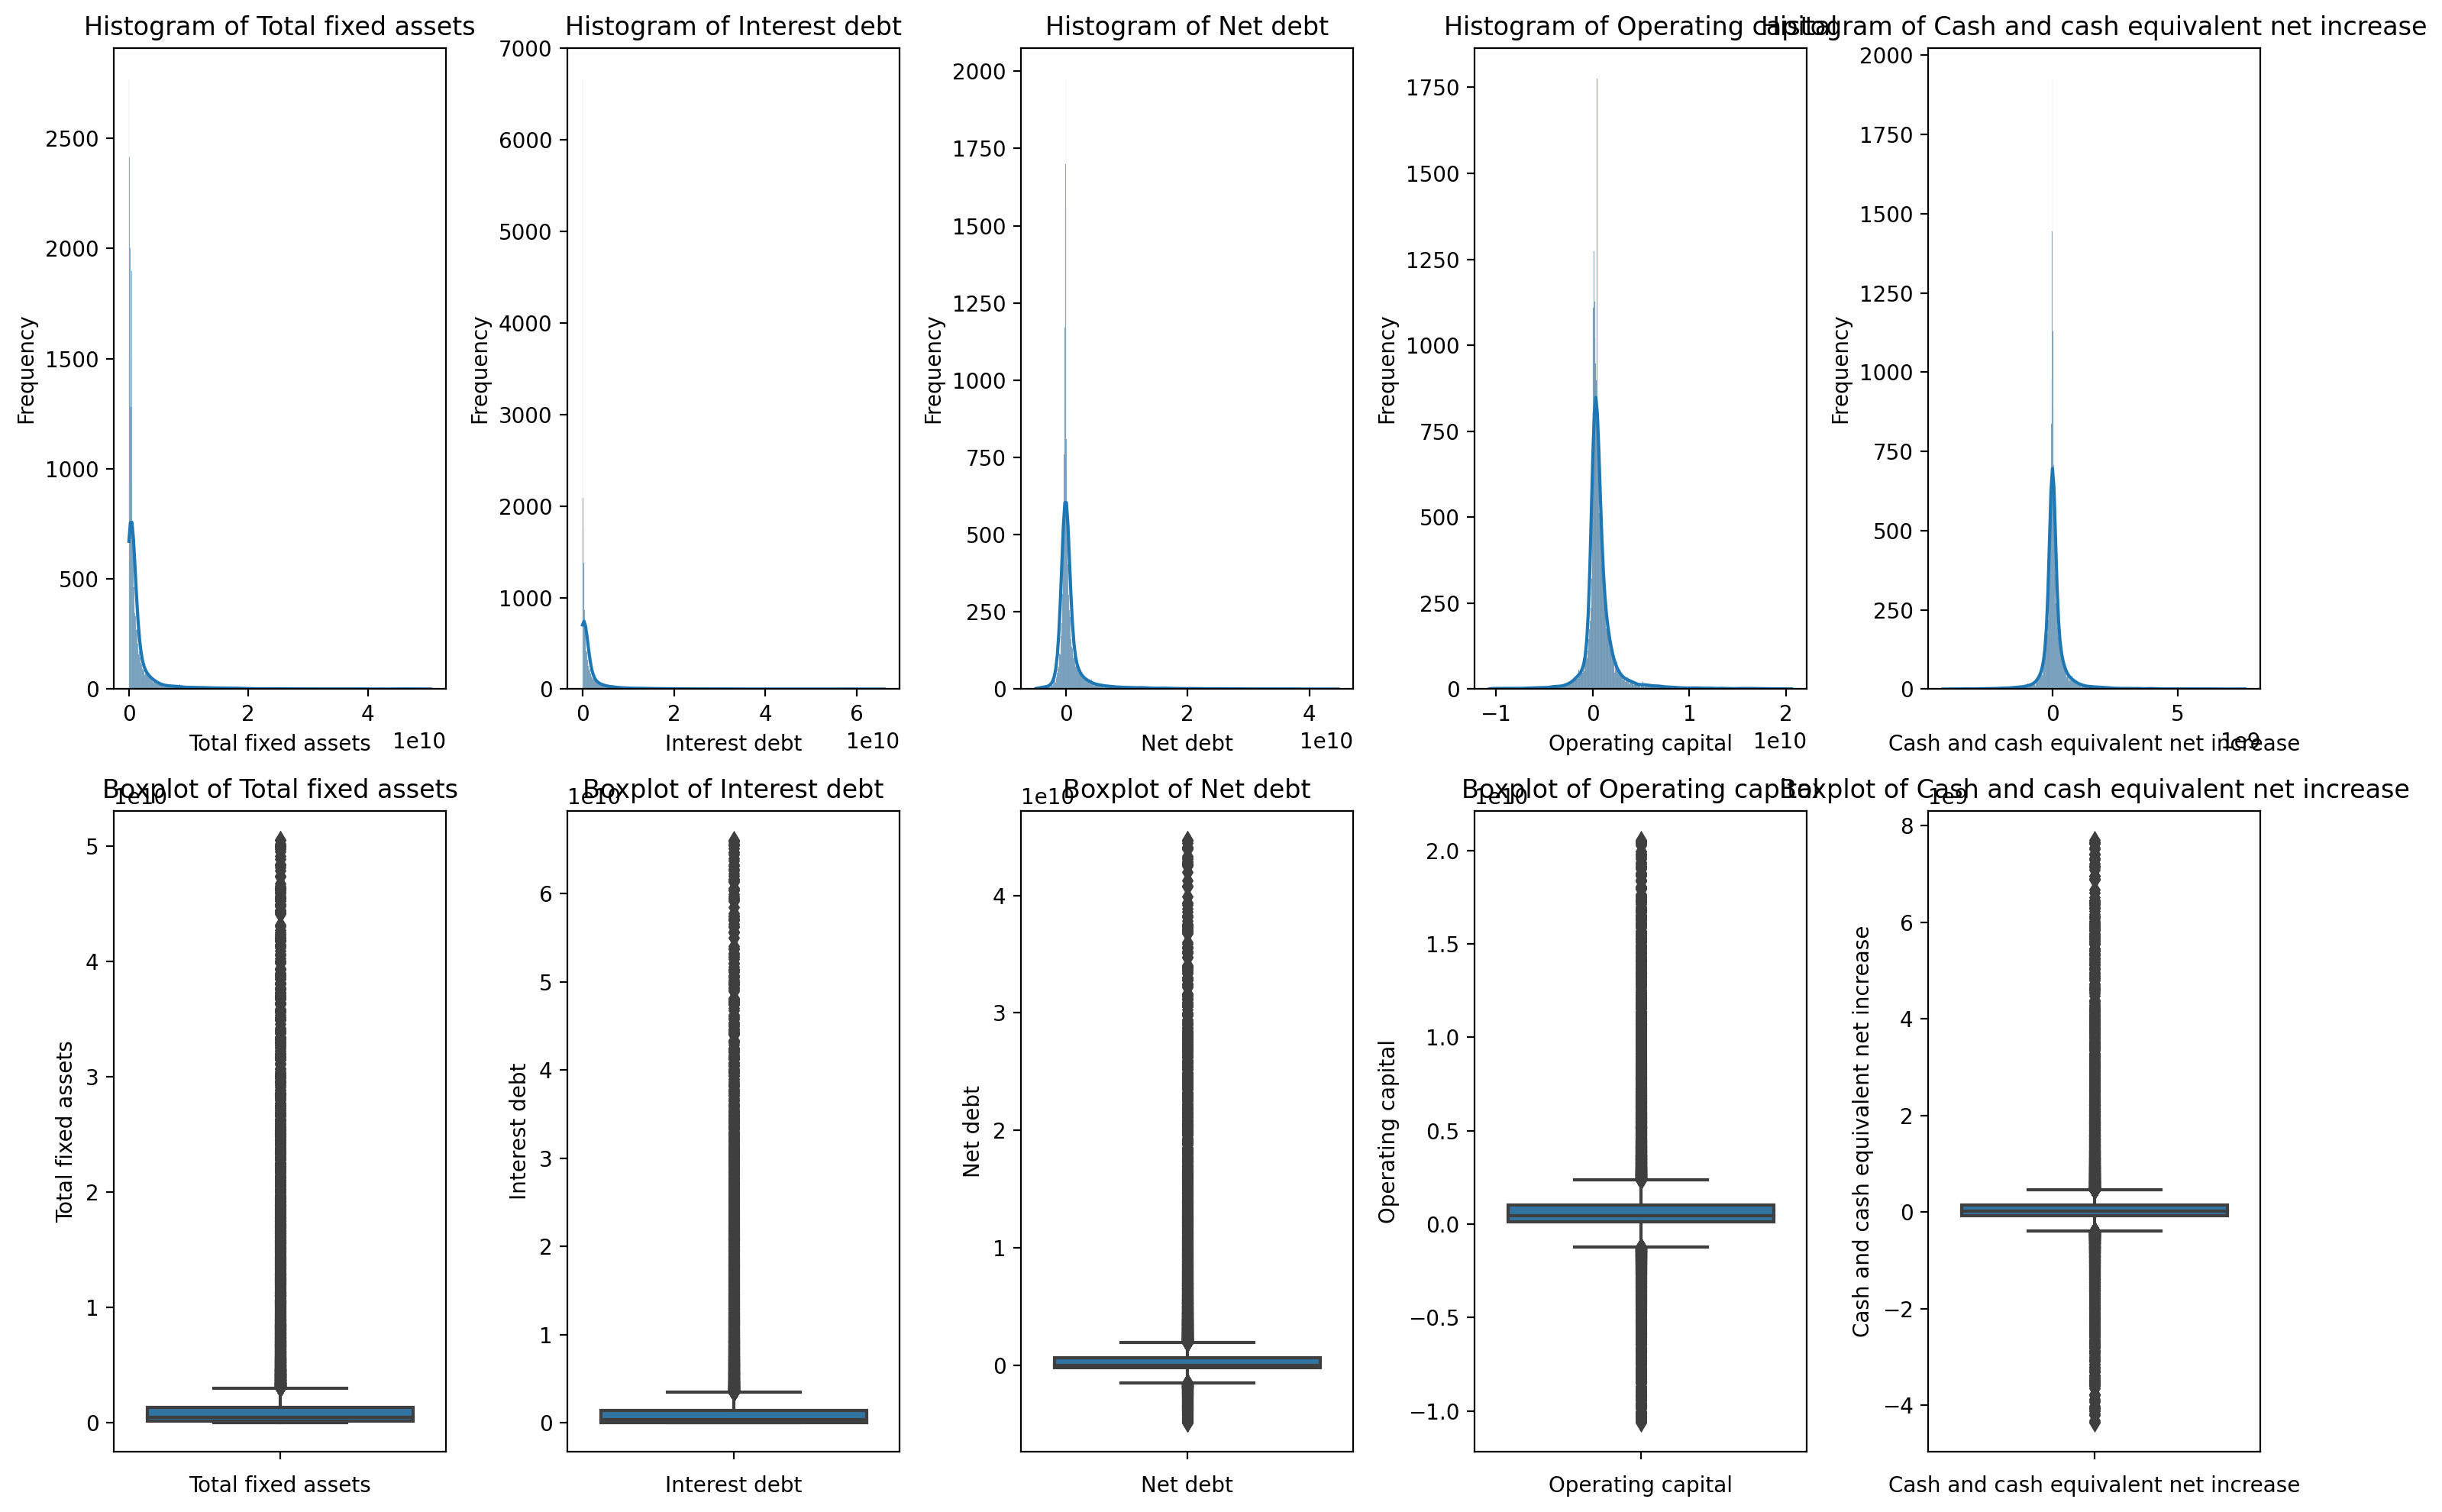

In [9]:
# Plotting histograms and boxplots for the available factors
selected_data = data_cleaned[selected_factors]

# Plotting
plt.figure(figsize=(15, 10), dpi=200)

for i, col in enumerate(selected_data.columns):
    # Histogram
    plt.subplot(2, len(selected_data.columns), i+1)
    sns.histplot(selected_data[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(2, len(selected_data.columns), len(selected_data.columns) + i+1)
    sns.boxplot(y=selected_data[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


#### Figure Explanation


**Histograms:**

1. **Total fixed assets:** The histogram is skewed to the right, with most data points concentrated near zero, suggesting most values in the data set are low with a few large outliers.
2. **Interest debt:** This also shows a right-skewed distribution, similar to total fixed assets, indicating that most companies have low interest debt with some exceptions.
3. **Net debt:** The distribution is right-skewed, meaning that most observations are clustered around lower values with few high-value outliers.
4. **Operating capital:** This histogram appears to be more centrally distributed but still shows a slight right-skewness, with most data points close to zero.
5. **Cash and cash equivalent net increase:** The histogram is quite skewed, with a long tail to the right, indicating that while most changes in cash and cash equivalents are small, there are cases with significant increases.

**Boxplots:**

1. **Total fixed assets:** The boxplot indicates a median near zero with a large number of outliers, which are represented by points above the upper whisker.
2. **Interest debt:** Similar to total fixed assets, the median is close to zero with many high-value outliers.
3. **Net debt:** The boxplot shows a median close to zero, with numerous outliers indicating significant variation in net debt among the sampled entities.
4. **Operating capital:** The median operating capital is around zero, with outliers on both sides, suggesting that while many entities have a balance around zero, there are significant deviations in both directions.
5. **Cash and cash equivalent net increase:** The median is slightly above zero, with many outliers above the upper whisker, showing that there are entities with significant increases in cash and cash equivalents.

**Summary and Conclusion:**

The provided financial metrics are highly right-skewed, indicating that a majority of the entities have low values for these financial items, with a small number of entities having very high values. This pattern is commonly seen in financial data where a few entities hold a majority of wealth or debt. The presence of outliers in all the boxplots indicates that there is considerable variability in each financial metric across the entities. The data suggest a financial landscape where most entities maintain conservative levels on these metrics, while a few have much larger scales of operation or debt.

## Exploratory Data Analysis

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

data_for_fixed_effects = data_cleaned.copy()
data_for_fixed_effects.set_index(['Stock number', 'Year (end of the year)'], inplace=True)

# clarify the exogenous variables, aka the independent variables
exog = sm.tools.tools.add_constant(data_for_fixed_effects[selected_factors])
dep_var = 'Whether to transfer'

vif = [variance_inflation_factor(exog.values, exog.columns.get_loc(i)) for i in exog.columns if i != 'const']
tol = [1./variance_inflation_factor(exog.values, exog.columns.get_loc(i)) for i in exog.columns if i != 'const']
print('vif', vif)
print('tol', tol)

# construct the panel data regression model
mod = PanelOLS(data_for_fixed_effects[dep_var], exog, entity_effects=True, time_effects=True)

# fit the model
fe_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(fe_res)

del data_for_fixed_effects


vif [1.6495951440973378, 3.681373811144104, 3.4875802782103023, 1.0945732507260046, 1.0600039963809502]
tol [0.6062093499597456, 0.2716377231165281, 0.28673175102170356, 0.9135980614698227, 0.9433926696636853]
                           PanelOLS Estimation Summary                           
Dep. Variable:     Whether to transfer   R-squared:                        0.0050
Estimator:                    PanelOLS   R-squared (Between):              0.0279
No. Observations:                22541   R-squared (Within):               0.0053
Date:                 Wed, Nov 15 2023   R-squared (Overall):              0.0104
Time:                         12:54:33   Log-likelihood                   -5319.0
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      19.279
Entities:                         3396   P-value                           0.0000
Avg Obs:                        6.6375   Distributio

## Prediction

### Data Split

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,confusion_matrix

data_for_pred = data_cleaned.copy()
data_for_pred = data_for_pred.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

x = data_for_pred.drop(columns=['Whether_to_transfer'])
y = data_for_pred['Whether_to_transfer']

train_x , validate_x , train_y , validate_y = train_test_split(x,y,test_size=0.2,random_state=2022)
train = pd.concat([train_x, train_y], axis=1)
train

,Stock_number,Year_end_of_the_year_,Total_fixed_assets,Interest_free_liability,Interest_free_non_current_liabilities,Interest_liabilities,Interest_debt,Net_debt,Formal_asset,Operating_capital,...,Dividement_profit_or_payment_of_interest_payment_cash,Payment_other_cash_related_to_fundraising_activities,Cash_outflow_of_fundraising_activities,Net_cash_flow_from_financing_activities,effect_of_the_changes_of_the_exchange_rate_on_cash_and_the_equivalents,Cash_and_cash_equivalent_net_increase,Add_At_the_beginning_of_the_period_of_cash_and_cash_equivalent,At_the_end_of_the_period_of_cash_and_cash_equivalent,Turn_per_share,Whether_to_transfer
3732,534.0,2.0,1.036652e+09,4.100114e+08,1.839772e+07,1.201440e+08,2.185730e+08,-2.474305e+08,1.527934e+09,8.376016e+08,...,8.350934e+07,2.450000e+06,2.757971e+08,-8.194866e+07,622061.63,-2.766716e+08,7.420621e+08,4.653904e+08,0.500,0.0
4450,636.0,6.0,5.651605e+08,6.465031e+07,0.000000e+00,3.592018e+08,5.967018e+08,4.582398e+08,5.539126e+08,9.984916e+07,...,3.323669e+07,1.713189e+07,4.626863e+08,-5.636657e+07,-8344.27,-3.538542e+07,1.738474e+08,1.384620e+08,0.051,0.0
7501,1072.0,5.0,2.783863e+09,7.955026e+08,3.687972e+08,5.318569e+08,1.106129e+09,6.130560e+08,1.120208e+09,-4.486421e+08,...,3.313070e+08,1.713189e+07,1.490080e+09,-5.539802e+08,-8344.27,-8.227961e+06,5.007056e+08,4.924776e+08,0.130,0.0
7518,1075.0,1.0,2.255047e+09,7.010259e+08,1.556989e+08,2.893575e+09,3.555254e+09,2.418593e+09,2.753147e+09,1.372483e+09,...,1.324191e+08,9.269952e+06,2.376219e+09,1.640691e+09,-19070104.73,-4.586953e+08,1.342628e+09,8.839322e+08,0.600,1.0
12221,1746.0,7.0,1.999377e+07,1.518444e+08,1.500000e+06,0.000000e+00,0.000000e+00,-4.313114e+08,6.154067e+08,5.970091e+08,...,1.613001e+06,3.786659e+07,7.947959e+07,1.832376e+08,-8344.27,2.347019e+08,1.932733e+08,4.279752e+08,0.200,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15080,2155.0,3.0,1.792363e+09,6.262994e+08,5.497636e+06,3.524383e+08,1.199105e+09,6.587364e+08,8.398488e+08,-7.406860e+07,...,5.958420e+07,1.713189e+07,6.789125e+08,3.770875e+08,-111685.08,-1.177851e+08,6.527537e+08,5.349686e+08,0.130,0.0
5088,727.0,7.0,2.532140e+08,9.734593e+07,3.474311e+07,3.933097e+08,3.933097e+08,-8.113867e+07,1.016532e+09,3.670815e+08,...,3.837069e+07,1.713189e+07,3.053707e+08,1.284093e+08,-8344.27,9.149154e+07,3.829569e+08,4.744484e+08,0.020,0.0
17842,2549.0,7.0,4.554365e+08,1.169656e+08,1.925262e+07,3.449600e+08,3.449600e+08,2.610295e+08,9.493414e+08,3.515573e+07,...,1.624475e+08,2.269666e+05,4.957345e+08,-1.041848e+08,-8344.27,-3.649701e+07,1.204275e+08,8.393046e+07,0.130,0.0
1363,195.0,6.0,4.143202e+08,1.112714e+09,5.499238e+07,3.049470e+07,3.049470e+07,-8.587096e+08,2.708711e+09,2.209818e+09,...,7.960188e+07,1.135110e+06,9.073698e+07,-8.573698e+07,11690470.34,-1.558115e+08,8.862048e+08,7.303933e+08,0.100,0.0


In [53]:
data_for_pred_cross_subject = data_cleaned.copy()
data_for_pred_cross_subject = data_for_pred_cross_subject.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
data_for_pred_cross_subject['Stock_number'] = data['Stock number']

grouped_cross_subject = data_for_pred_cross_subject.groupby('Stock_number', group_keys=False)

def train_test_split_by_stock_id(group):
    return train_test_split(group, test_size=0.2, random_state=2022)

train_df_cross_subject, test_df_cross_subject = zip(*grouped_cross_subject.apply(train_test_split_by_stock_id))

train_df_cross_subject = pd.concat(train_df_cross_subject)
test_df_cross_subject = pd.concat(test_df_cross_subject)

train_x_cross = train_df_cross_subject.drop(columns=['Whether_to_transfer'])
train_y_cross = train_df_cross_subject['Whether_to_transfer']
validate_x_cross = test_df_cross_subject.drop(columns=['Whether_to_transfer'])
validate_y_cross = test_df_cross_subject['Whether_to_transfer']
train_cross = pd.concat([train_x_cross, train_y_cross], axis=1)


In [54]:
data_for_pred_within_subject = data_cleaned.copy()
data_for_pred_within_subject = data_for_pred_within_subject.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
data_for_pred_within_subject['Stock_number'] = data['Stock number']

train_df_within_subject = data_for_pred_within_subject[data_for_pred_within_subject['Year_end_of_the_year_'].isin([2, 3, 4, 5, 6, 7])]
test_df_within_subject = data_for_pred_within_subject[data_for_pred_within_subject['Year_end_of_the_year_'].isin([1])]

train_x_within = train_df_within_subject.drop(columns=['Whether_to_transfer'])
train_y_within = train_df_within_subject['Whether_to_transfer']
validate_x_within = test_df_within_subject.drop(columns=['Whether_to_transfer'])
validate_y_within = test_df_within_subject['Whether_to_transfer']
train_within = pd.concat([train_x_within, train_y_within], axis=1)

In [49]:
train_x

,Stock_number,Year_end_of_the_year_,Total_fixed_assets,Interest_free_liability,Interest_free_non_current_liabilities,Interest_liabilities,Interest_debt,Net_debt,Formal_asset,Operating_capital,...,Cash_for_repayment_of_debt_payment,Dividement_profit_or_payment_of_interest_payment_cash,Payment_other_cash_related_to_fundraising_activities,Cash_outflow_of_fundraising_activities,Net_cash_flow_from_financing_activities,effect_of_the_changes_of_the_exchange_rate_on_cash_and_the_equivalents,Cash_and_cash_equivalent_net_increase,Add_At_the_beginning_of_the_period_of_cash_and_cash_equivalent,At_the_end_of_the_period_of_cash_and_cash_equivalent,Turn_per_share
3,1,4.0,6.406923e+07,1.388840e+09,1.367301e+08,1.050000e+08,2.826134e+08,-5.263500e+08,1.755344e+09,1.697810e+09,...,514316666.6,1.787611e+08,17131885.01,6.930777e+08,-3.767077e+08,-1093973.32,-1.682084e+08,9.771718e+08,8.089634e+08,0.22
1,1,2.0,7.887817e+07,1.903724e+09,1.487364e+08,3.749099e+08,3.942266e+08,-4.034978e+08,1.190906e+09,9.114353e+08,...,618961878.7,4.891714e+07,1584500.00,6.694635e+08,-4.834635e+08,1103.36,3.284106e+08,4.693137e+08,7.977243e+08,0.13
0,1,1.0,8.691229e+07,1.422495e+09,1.600192e+08,8.198551e+08,8.271884e+08,3.578747e+08,8.929308e+08,5.904970e+08,...,278960000.0,4.396870e+07,1396200.00,3.243249e+08,2.881703e+08,-217885.53,-7.615285e+07,5.454666e+08,4.693137e+08,0.13
4,1,5.0,8.592952e+07,1.870206e+09,1.347049e+08,1.292434e+08,2.740834e+08,-6.716566e+08,1.764907e+09,1.665822e+09,...,225000000.0,1.492891e+08,104500.00,3.743936e+08,-1.579236e+08,2757607.83,1.243744e+08,8.089634e+08,9.333378e+08,0.08
5,1,6.0,7.401756e+07,4.105670e+09,1.373895e+08,0.000000e+00,0.000000e+00,-2.869755e+09,1.947454e+09,1.522360e+09,...,289524641.1,5.283094e+07,17131885.01,3.423556e+08,-3.269143e+08,3403855.84,1.924015e+09,9.333378e+08,2.857353e+09,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24258,3466,4.0,1.674375e+08,1.017815e+08,1.360359e+07,2.314488e+07,2.314488e+07,-1.139792e+08,3.873122e+08,2.294332e+08,...,80000000.0,1.615895e+07,17131885.01,9.615895e+07,6.047802e+07,-8344.27,7.917448e+07,5.212024e+07,1.312947e+08,0.20
24256,3466,2.0,1.177136e+08,1.029509e+08,5.410139e+06,3.861174e+07,3.861174e+07,2.849277e+06,2.146996e+08,7.293212e+07,...,30000000.0,2.261906e+07,17131885.01,5.261906e+07,-2.261906e+07,-8344.27,-3.284487e+07,6.685245e+07,3.400758e+07,0.13
24255,3466,1.0,8.183569e+07,1.174028e+08,4.247179e+06,3.000000e+07,3.000000e+07,-3.685245e+07,1.727680e+08,9.166820e+07,...,42900000.0,1.550184e+06,17131885.01,4.445018e+07,-1.445018e+07,-8344.27,-3.365590e+07,1.005084e+08,6.685245e+07,0.13
24259,3466,5.0,1.627839e+08,8.110693e+07,1.326047e+07,1.415562e+07,1.415562e+07,-1.464317e+06,3.651500e+08,2.133559e+08,...,414566287.4,1.562120e+07,17131885.01,1.562120e+07,-1.110120e+07,-8344.27,-1.178085e+08,1.312947e+08,1.348623e+07,0.11


### Logistics Regression Prediction

In [86]:
# run a basic linear regression model to predict the probability of transfer
import sklearn.linear_model as lm

# define the model
model = lm.LogisticRegression()

# fit the model
model.fit(train_x, train_y)

# predict the probability of transfer
pred_y = model.predict_proba(validate_x)[:, 1]

# convert the probability to binary labels
pred_y_label = np.where(pred_y >= 0.5 , 1, 0)

# calculate the confusion matrix
confusion_matrix(validate_y, pred_y_label)

# calculate the precision score
precision_score(validate_y, pred_y_label)


0.5471698113207547

#### Confusion Matrix

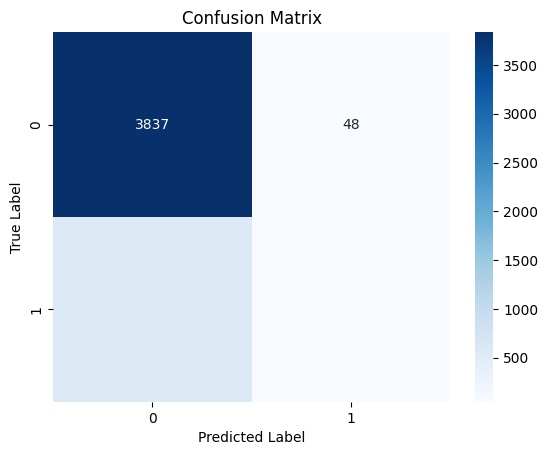

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(validate_y, pred_y_label)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


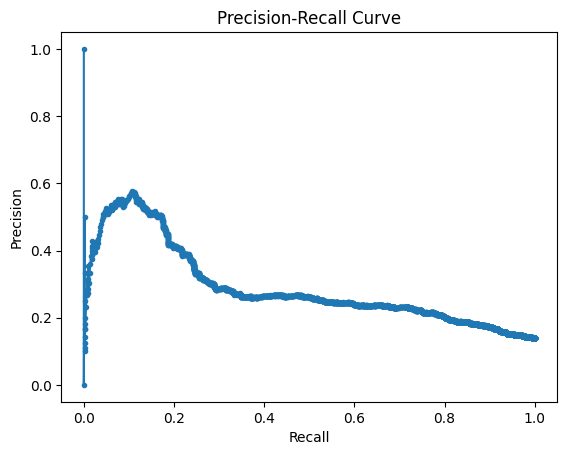

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(validate_y, pred_y)

# Plot Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()



#### ROC curve

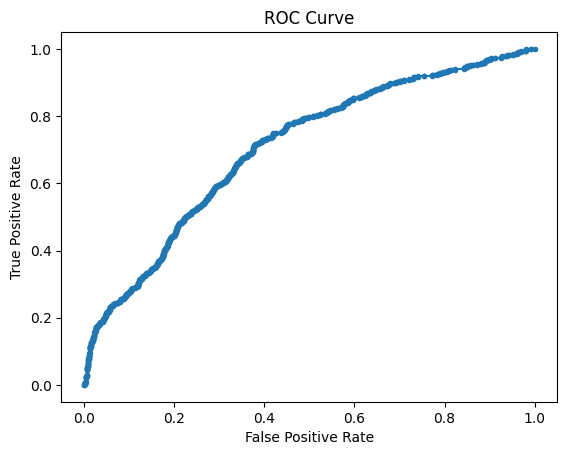

In [89]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(validate_y, pred_y)

# Plot ROC curve
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


#### Coefficient

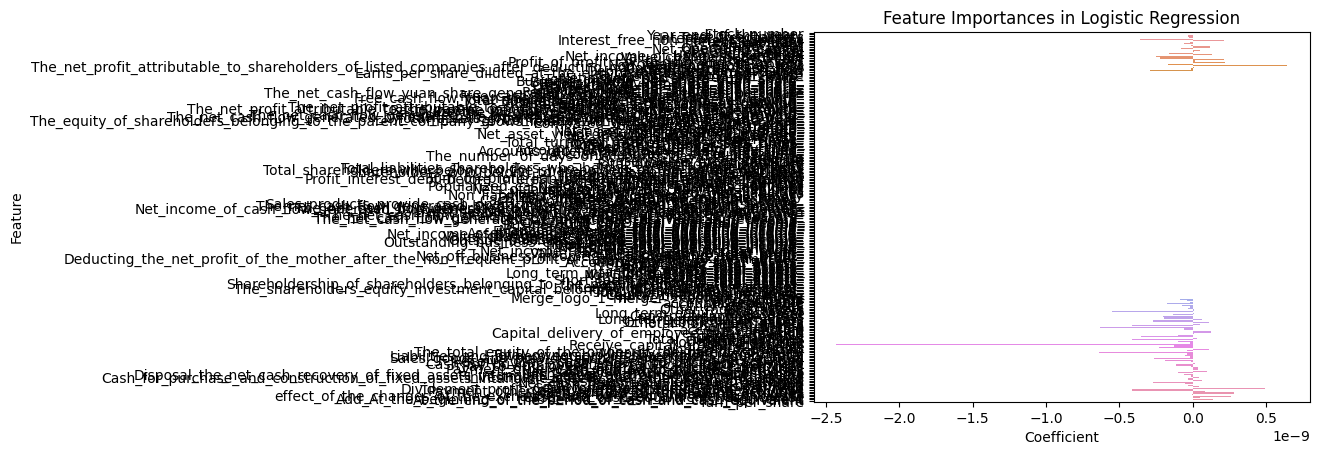

In [90]:
# Coefficient plot
feature_names = train_x.columns
coefficients = model.coef_[0]

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Plot the coefficients
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Importances in Logistic Regression')
plt.show()


### LightGBM + TPE

In [35]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe


In [63]:
def params_append(params):
    """
    动态回调参数函数，params视作字典
    :param params:lgb参数字典
    :return params:修正后的lgb参数字典
    """
    params['feature_pre_filter'] = False
    params['boosting'] = 'dart'
    params['objective'] = 'binary'
    # 分类问题评价指标
    params['metric'] = 'binary_logloss'
    params['bagging_seed'] = 2022
    return params

In [70]:
def param_hyperopt(train):
    """
    模型参数搜索与优化函数
    :param train:训练数据集
    :return params_best:lgb最优参数
    """
    # Part 1.划分特征名称，删除ID列和标签列
    label = 'Whether_to_transfer'
    features = train.columns.tolist()
    features.remove('Whether_to_transfer')

    # Part 2.封装训练数据
    train_data = lgb.Dataset(train[features], train[label])

    # Part 3.内部函数，输入模型超参数损失值输出函数
    def hyperopt_objective(params):
        """
        输入超参数，输出对应损失值
        :param params:
        :return:最小binary_logloss损失值
        """
        # 创建参数集
        params = params_append(params)
        # print(params)

        # 借助lgb的cv过程，输出某一组超参数下损失值的最小值
        res = lgb.cv(params, train_data, 1000,
                     nfold=5,
                     stratified=False,
                     shuffle=True,
                    #  show_stdv=False,
                     seed=2022)
        return min(res['valid binary_logloss-mean'])  # res是个字典

    # Part 4.lgb超参数空间
    params_space = {
        'learning_rate': hp.uniform('learning_rate', 1e-2, 5e-1),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
        'num_leaves': hp.choice('num_leaves', list(range(20, 300, 10))),
        'reg_alpha': hp.randint('reg_alpha', 0, 10),
        # 'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'bagging_freq': hp.randint('bagging_freq', 1, 10),
        'min_child_samples': hp.choice('min_child_samples', list(range(1, 30, 5))),
        'lambda_l1': hp.uniform('lambda_l1', 0, 10),
        'lambda_l2': hp.uniform('lambda_l2', 0, 10),
        'verbose': -1
    }

    # Part 5.TPE超参数搜索
    params_best = fmin(
        hyperopt_objective,
        space=params_space,
        algo=tpe.suggest,
        max_evals=30,
        rstate=np.random.default_rng(2022)
    )

    # 返回最佳参数
    return params_best

In [36]:
data_cleaned

,Stock number,Year (end of the year),Total fixed assets,Interest -free liability,Interest -free non -current liabilities,Interest liabilities,Interest debt,Net debt,Formal asset,Operating capital,...,"Dividement, profit, or payment of interest payment cash",Payment other cash related to fundraising activities,Cash outflow of fundraising activities,Net cash flow from financing activities,effect of the changes of the exchange rate on cash and the equivalents,Cash and cash equivalent net increase,Add: At the beginning of the period of cash and cash equivalent,At the end of the period of cash and cash equivalent,Turn per share,Whether to transfer
0,1731.0,1.0,8.691229e+07,1.422495e+09,1.600192e+08,8.198551e+08,8.271884e+08,3.578747e+08,8.929308e+08,5.904970e+08,...,4.396870e+07,1396200.00,3.243249e+08,2.881703e+08,-217885.53,-7.615285e+07,5.454666e+08,4.693137e+08,0.13,0.0
1,1731.0,2.0,7.887817e+07,1.903724e+09,1.487364e+08,3.749099e+08,3.942266e+08,-4.034978e+08,1.190906e+09,9.114353e+08,...,4.891714e+07,1584500.00,6.694635e+08,-4.834635e+08,1103.36,3.284106e+08,4.693137e+08,7.977243e+08,0.13,0.0
2,1731.0,3.0,7.530102e+07,1.447218e+09,1.418316e+08,3.643167e+08,4.805600e+08,-4.966118e+08,1.501162e+09,1.333070e+09,...,2.337307e+07,1677492.00,3.973809e+08,6.386246e+07,-801465.87,1.794475e+08,7.977243e+08,9.771718e+08,0.25,0.0
3,1731.0,4.0,6.406923e+07,1.388840e+09,1.367301e+08,1.050000e+08,2.826134e+08,-5.263500e+08,1.755344e+09,1.697810e+09,...,1.787611e+08,17131885.01,6.930777e+08,-3.767077e+08,-1093973.32,-1.682084e+08,9.771718e+08,8.089634e+08,0.22,0.0
4,1731.0,5.0,8.592952e+07,1.870206e+09,1.347049e+08,1.292434e+08,2.740834e+08,-6.716566e+08,1.764907e+09,1.665822e+09,...,1.492891e+08,104500.00,3.743936e+08,-1.579236e+08,2757607.83,1.243744e+08,8.089634e+08,9.333378e+08,0.08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,1731.0,3.0,1.749089e+08,9.162246e+07,1.583035e+07,6.589091e+07,6.589091e+07,9.880669e+06,2.252468e+08,6.080053e+07,...,2.466474e+07,17131885.01,5.466474e+07,5.335261e+06,-8344.27,1.811266e+07,3.400758e+07,5.212024e+07,0.13,0.0
24258,1731.0,4.0,1.674375e+08,1.017815e+08,1.360359e+07,2.314488e+07,2.314488e+07,-1.139792e+08,3.873122e+08,2.294332e+08,...,1.615895e+07,17131885.01,9.615895e+07,6.047802e+07,-8344.27,7.917448e+07,5.212024e+07,1.312947e+08,0.20,0.0
24259,1731.0,5.0,1.627839e+08,8.110693e+07,1.326047e+07,1.415562e+07,1.415562e+07,-1.464317e+06,3.651500e+08,2.133559e+08,...,1.562120e+07,17131885.01,1.562120e+07,-1.110120e+07,-8344.27,-1.178085e+08,1.312947e+08,1.348623e+07,0.11,0.0
24260,1731.0,6.0,1.897513e+08,1.432359e+08,1.203168e+07,2.974001e+07,2.974001e+07,-4.736971e+07,3.793057e+08,2.000272e+08,...,8.697808e+06,17131885.01,8.697808e+06,-6.697808e+06,-8344.27,5.956293e+07,1.348623e+07,7.304916e+07,0.11,0.0


In [71]:
best_params = param_hyperopt(train)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

{'valid binary_logloss-mean': [0.3653512844591327, 0.2945271551275156, 0.2498156129282861, 0.21667409094019058, 0.19040211598123136, 0.18103667041969068, 0.16099279100622077, 0.16989707780610538, 0.15165332644586876, 0.13625703249782184, 0.12312656604426656, 0.1283130603382029, 0.11637965347925194, 0.10618861546894436, 0.09662951400543318, 0.08777605808409444, 0.07991350078081969, 0.07796639056165894, 0.07157286264826238, 0.0697877787057935, 0.07151647093939914, 0.0697539137441352, 0.06800901476907595, 0.06299839658451277, 0.058279734057910725, 0.05426904935308839, 0.05071677852625619, 0.05255540636945451, 0.0516073267937618, 0.04836697615870804, 0.049991272002067176, 0.049284444343288374, 0.046449078165590615, 0.043770657835715016, 0.04458567539609369, 0.04643509649903997, 0.0457648894838866, 0.043043657440235736, 0.04071218545778688, 0.04025761708116941, 0.04142081474642965, 0.04095740147906929, 0.04165457031438142, 0.03941526176563469, 0.03745309468204033, 0.03892423856087044, 0.037

In [72]:
best_params

{'bagging_fraction': 0.8661978889819648,
 'bagging_freq': 2,
 'feature_fraction': 0.559324020459147,
 'lambda_l1': 1.4738554707297031,
 'lambda_l2': 0.13294538437096992,
 'learning_rate': 0.3397847325510154,
 'min_child_samples': 5,
 'num_leaves': 11,
 'reg_alpha': 3}

In [73]:
# 再次申明固定参数
best_params = params_append(best_params)

# 数据准备过程
label = 'Whether_to_transfer'
features = train.columns.tolist()
features.remove('Whether_to_transfer')

bst = lgb.train(best_params, lgb.Dataset(train[features], train[label]), 1000)



[LightGBM] [Warning] lambda_l1 is set=1.4738554707297031, reg_alpha=3 will be ignored. Current value: lambda_l1=1.4738554707297031
[LightGBM] [Warning] lambda_l1 is set=1.4738554707297031, reg_alpha=3 will be ignored. Current value: lambda_l1=1.4738554707297031
[LightGBM] [Info] Number of positive: 2537, number of negative: 15495
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59215
[LightGBM] [Info] Number of data points in the train set: 18032, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140694 -> initscore=-1.809535
[LightGBM] [Info] Start training from score -1.809535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

In [76]:
pred_y = bst.predict(validate_x)

pred_y_label = np.where(pred_y >= 0.50, 1, 0)

In [77]:
confusion_matrix(validate_y,pred_y_label)


array([[3883,    2],
       [  15,  609]], dtype=int64)

In [78]:
precision_score(validate_y,pred_y_label)

0.9967266775777414

### XGBoost + Bayes

In [91]:
import xgboost as xgb
from bayes_opt import BayesianOptimization

# 参数回调函数
def params_append(params):
    """

    :param params:
    :return:
    """
    params['booster'] = 'dart'
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    params["min_child_weight"] = int(params["min_child_weight"])
    params['max_depth'] = int(params['max_depth'])
    return params

# 模型优化函数


def param_beyesian(train_x, train_y):
    """

    :param train:
    :return:
    """

    # 数据封装
    # train_x,validate_x,train_y,validate_y = train_test_split(train,y,test_size=0.2,random_state=0)
    train_data = xgb.DMatrix(train_x, train_y, silent=True)

    # 借助cv过程构建目标函数
    def xgb_cv(colsample_bytree, subsample, min_child_weight, max_depth,
               reg_alpha, eta,
               reg_lambda):
        """

        :param colsample_bytree:
        :param subsample:
        :param min_child_weight:
        :param max_depth:
        :param reg_alpha:
        :param eta:
        :param reg_lambda:
        :return:
        """
        params = {'objective': 'binary:logistic',
                  'eval_metric': 'auc'}
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params["min_child_weight"] = int(min_child_weight)
        params['max_depth'] = int(max_depth)
        params['eta'] = float(eta)
        params['reg_alpha'] = max(reg_alpha, 0)
        params['reg_lambda'] = max(reg_lambda, 0)
        # print(params)
        cv_result = xgb.cv(params, train_data,
                           num_boost_round=1000,
                           nfold=5, seed=2,
                           stratified=False,
                           shuffle=True,
                           early_stopping_rounds=30,
                           verbose_eval=False)
        return max(cv_result['test-auc-mean'])

    # 调用贝叶斯优化器进行模型优化
    xgb_bo = BayesianOptimization(
        xgb_cv,
        {'colsample_bytree': (0.1, 1),
         'subsample': (0.1, 1),
         'min_child_weight': (1, 30),
         'max_depth': (3, 15),
         'reg_alpha': (0, 5),
         'eta': (0.02, 0.2),
         'reg_lambda': (0, 5)}
    )
    # init_points表示初始点，n_iter代表迭代次数（即采样数）
    xgb_bo.maximize(init_points = 5, n_iter = 5)
    print(xgb_bo.max['target'], xgb_bo.max['params'])
    return xgb_bo.max['params']

In [96]:
params_best = param_beyesian(train_x, train_y)

|   iter    |  target   | colsam... |    eta    | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9988    | 0.3655    | 0.02132   | 12.48     | 19.84     | 4.196     | 4.154     | 0.7582    |
| 2         | 0.9986    | 0.9885    | 0.1764    | 12.59     | 20.29     | 3.825     | 2.568     | 0.9403    |
| 3         | 0.9986    | 0.2629    | 0.1507    | 7.005     | 14.63     | 1.748     | 2.757     | 0.5191    |
| 4         | 0.998     | 0.2746    | 0.04817   | 8.961     | 1.689     | 1.865     | 2.219     | 0.9132    |
| 5         | 0.9989    | 0.6434    | 0.1518    | 4.026     | 14.7      | 1.904     | 4.156     | 0.9137    |
| 6         | 0.9979    | 0.7981    | 0.02742   | 3.033     | 18.09     | 1.788     | 4.802     | 0.3844    |
| 7         | 0.998     | 0.4018    | 0.1823    | 3.993     | 13.27     | 1.943     | 4.346     | 0.2632    |
| 8       

In [97]:
params = params_append(params_best)

train_part_x,eval_part_x,train_part_y,eval_part_y = train_test_split(train_x,train_y,test_size=0.2,random_state=0)

train_part = xgb.DMatrix(train_x, train_y, silent=True)

ESR = 80
NBR = 10000
VBE = 5
bst = xgb.train(params, train_part, NBR, [(train_part, 'train')], verbose_eval=VBE,
                maximize=False, early_stopping_rounds=ESR, )

pred_y = bst.predict(xgb.DMatrix(validate_x))
pred_y_label = np.where(pred_y >= 0.5, 1, 0)

confusion_matrix(validate_y, pred_y_label)

[0]	train-auc:0.97899
[5]	train-auc:0.99553
[10]	train-auc:0.99603
[15]	train-auc:0.99687
[20]	train-auc:0.99695
[25]	train-auc:0.99714
[30]	train-auc:0.99739
[35]	train-auc:0.99750
[40]	train-auc:0.99776
[45]	train-auc:0.99790
[50]	train-auc:0.99799
[55]	train-auc:0.99814
[60]	train-auc:0.99826
[65]	train-auc:0.99843
[70]	train-auc:0.99852
[75]	train-auc:0.99856
[79]	train-auc:0.99861


array([[3883,    2],
       [  45,  579]], dtype=int64)

In [98]:
precision_score(validate_y, pred_y_label)

0.9965576592082617